In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

## Loading Dataset <a id="02"></a>

In [2]:
data = pd.read_csv('input/age_gender.csv')

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [3]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 23705
Total columns: 5


## Distributions <a id="03"></a>

In [4]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

### Ethnicity Distribution <a id="3.2"></a>

In [6]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

In [7]:
X = np.array(data['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

### Sample Images <a id="3.4"></a>

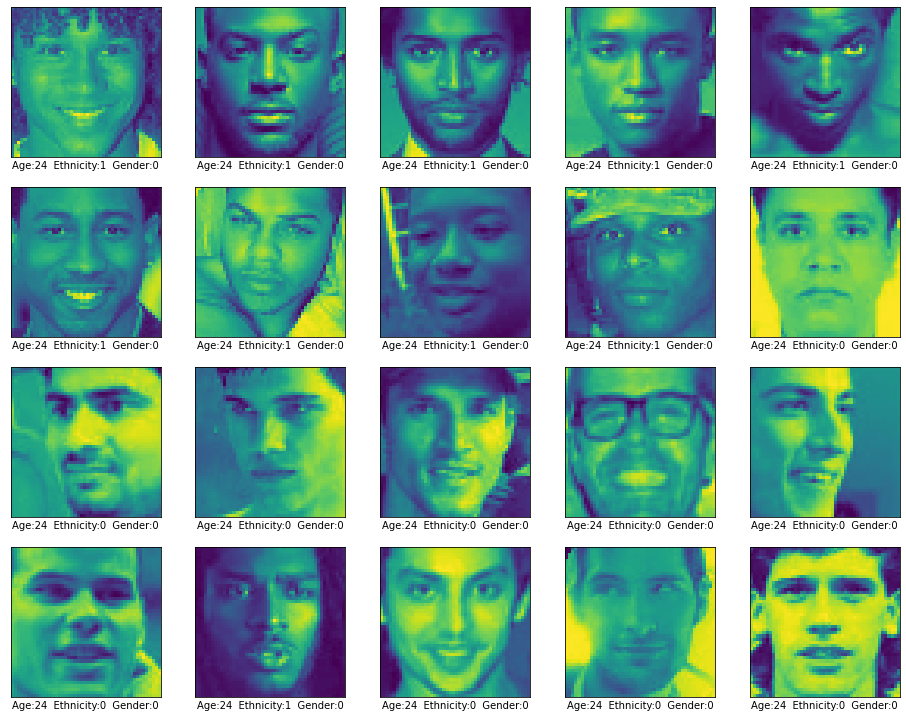

In [311]:
plt.figure(figsize=(16,16))
for i in range(5000,5020):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

## Ethnicity Model

### Split data into train/test <a id="5.1"></a>

In [12]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="5.2"></a>

In [83]:
eth_model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.1),
    L.Dense(5)
])

eth_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Stop training when validation accuracy reach 79%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True
    
callback = myCallback()


eth_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                409664    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)               

In [84]:
eth_history = eth_model.fit(
    X_train, y_train, epochs=50, validation_split=0.1, batch_size=32, callbacks=[callback]
)


Epoch 1/50
520/520 [==============================] - 30s 58ms/step - loss: 1.0572 - accuracy: 0.6093 - val_loss: 0.8164 - val_accuracy: 0.7198
Epoch 2/50
520/520 [==============================] - 33s 63ms/step - loss: 0.8033 - accuracy: 0.7158 - val_loss: 0.7133 - val_accuracy: 0.7447
Epoch 3/50
520/520 [==============================] - 35s 67ms/step - loss: 0.7240 - accuracy: 0.7453 - val_loss: 0.6563 - val_accuracy: 0.7674
Epoch 4/50
520/520 [==============================] - 31s 60ms/step - loss: 0.6640 - accuracy: 0.7690 - val_loss: 0.6546 - val_accuracy: 0.7674
Epoch 5/50
520/520 [==============================] - 29s 57ms/step - loss: 0.6119 - accuracy: 0.7885 - val_loss: 0.6255 - val_accuracy: 0.7826
Epoch 6/50
520/520 [==============================] - 34s 65ms/step - loss: 0.5717 - accuracy: 0.8026 - val_loss: 0.6326 - val_accuracy: 0.7869
Epoch 7/50
520/520 [==============================] - ETA: 0s - loss: 0.5375 - accuracy: 0.8129
Reached 79% val_accuracy so cancelling t

### Evaluate training history <a id="5.3"></a>

In [87]:
fig = px.line(
    eth_history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [88]:
fig = px.line(
    eth_history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}, 
    title='Training History')
fig.show()

In [111]:
loss, acc = eth_model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.6019036173820496
Test Accuracy: 0.7988880276679993


### Prediction

In [263]:
def Predict(image):                    #Takes RGB image as input
    image=cv.resize(image,(48,48))
    gray=cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    new_image=[]
    for rows in gray:
        row=[]
        for pixel in rows:
            value=[pixel/255.0]
            row.append(value)
        new_image.append(row)
    test_image=np.array(new_image,dtype='float32')
    plt.imshow(test_image)
    test_image=tf.expand_dims(test_image,0)
    result=eth_model.predict(test_image)
    return np.argmax(result)

In [260]:
image=plt.imread("kid.jpg")

In [251]:
import cv2 as cv

In [252]:
image=cv.resize(image,(48,48))

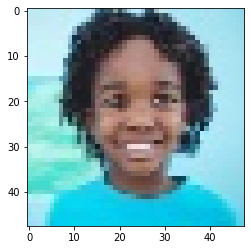

In [253]:
plt.imshow(image)

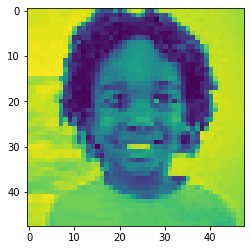

In [264]:
ethnicity=Predict(image)

In [332]:
ethnicity

1

In [294]:
def Capture_from_webcam():
    cam=cv.VideoCapture(0)
    while (cam.isOpened()):
        ret,frame=cam.read()
        cv.imshow("Press C to capture while looking in the camera: ",frame[:,::-1])
        if cv.waitKey(15)& 0xFF==ord('c'):
            break
    cam.release()
    cv.destroyAllWindows()
    return frame

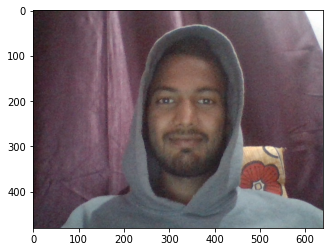

In [307]:
img=Capture_from_webcam()
plt.imshow(img[:,:,::-1])

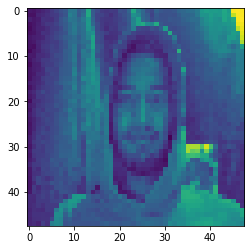

In [308]:
ethnicity=Predict(img)

In [309]:
ethnicity

1

In [333]:
def predict_from_dataset(index):        #takes index number of the image to be predicted.
    img=data['pixels'].iloc[index].reshape(48,48)
    new_image=[]
    for rows in img:
        row=[]
        for pixel in rows:
            value=[pixel]
            row.append(value)
        new_image.append(row)
    test_image=np.array(new_image,dtype='float32')
    plt.imshow(test_image)
    test_image=tf.expand_dims(test_image,0)
    result=eth_model.predict(test_image)
    return np.argmax(result)
    

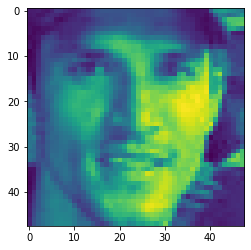

In [340]:
eth=predict_from_dataset(5012)

In [341]:
eth

0

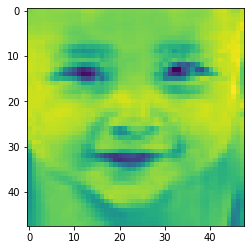

In [342]:
eth2=predict_from_dataset(5)

In [343]:
eth2

2

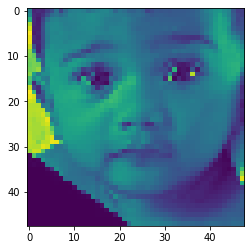

In [344]:
eth3=predict_from_dataset(75)

In [345]:
eth3

3

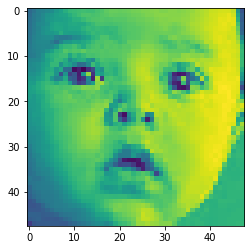

In [346]:
eth4=predict_from_dataset(170)

In [347]:
eth4

0

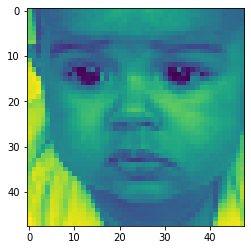

In [348]:
eth5=predict_from_dataset(180)

In [349]:
eth5

4

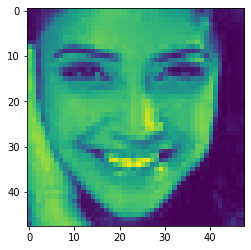

In [350]:
eth6=predict_from_dataset(3240)

In [351]:
eth6

3

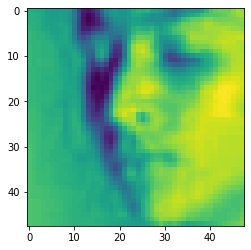

In [352]:
eth7=predict_from_dataset(3243)

In [354]:
eth7

3

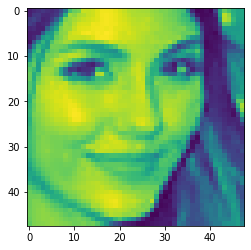

In [355]:
eth8=predict_from_dataset(3250)

In [356]:
eth8

4